# Cuffless Blood Pressure Feature Extraction

## Data Set Information:

The main goal of this data set is providing clean and valid signals for designing cuff-less blood pressure estimation algorithms. The raw electrocardiogram (ECG), photoplethysmograph (PPG), and arterial blood pressure (ABP) signals are originally collected from the physionet.org and then some preprocessing and validation performed on them.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.fft import fft
from scipy.signal import find_peaks, correlate
from scipy.io import loadmat
import matplotlib.pyplot as plt 

In [2]:
%%time

sample_file = loadmat('dataset/archive/part_1.mat')['p'][0]
sample_file

CPU times: total: 3.3 s
Wall time: 3.58 s


array([array([[ 1.75953079e+00,  1.71847507e+00,  1.68426197e+00, ...,
                1.64418377e+00,  1.60019550e+00,  1.56598240e+00],
              [ 6.70629552e+01,  6.93586281e+01,  7.53664529e+01, ...,
                7.64410232e+01,  8.18138747e+01,  9.13873191e+01],
              [-6.06060606e-02, -7.52688172e-02, -7.03812317e-02, ...,
               -1.00195503e-01, -9.04203324e-02, -4.54545455e-02]])   ,
       array([[ 2.40957967,  2.32942326,  2.23851417, ...,  1.24046921,
                1.23069404,  1.21994135],
              [73.75459745, 73.1684682 , 72.53349484, ..., 99.15353167,
               96.22288542, 93.19455095],
              [ 0.18475073,  0.17986315,  0.16959922, ...,  0.29472141,
                0.31964809,  0.33968719]])                             ,
       array([[  1.21212121,   1.20136852,   1.19354839, ...,   1.34506354,
                 1.33040078,   1.31671554],
              [ 94.80640639,  91.87576014,  88.55436105, ..., 127.38542394,
            

In [3]:
sample_file.shape

(1000,)

In [4]:
sample_file[0].shape

(3, 61000)

## Attribute Information:

This database consists of a cell array of matrices, each cell is one record part.
In each matrix each row corresponds to one signal channel:

1: PPG signal, FS=125Hz; photoplethysmograph from fingertip

2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)

3: ECG signal, FS=125Hz; electrocardiogram from channel II

In [5]:
SAMPLING_FREQUENCY = 125
EPSILON = 1e-9

**Sampling Frequency**: Sampling rate or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal.

### Feature Extraction and Analysis

In [6]:
%%time

ppg_signals = {}
abp_signals = {}
ecg_signals = {}

for i in range(sample_file.shape[0]):
    
    rec_matrix = sample_file[i]
    ppg_signals["patient_{}".format(i + 1)] = np.squeeze(rec_matrix[0])
    abp_signals["patient_{}".format(i + 1)] = np.squeeze(rec_matrix[1])
    ecg_signals["patient_{}".format(i + 1)] = np.squeeze(rec_matrix[2])
    
ppg_signals

CPU times: total: 0 ns
Wall time: 5.99 ms


{'patient_1': array([1.75953079, 1.71847507, 1.68426197, ..., 1.64418377, 1.6001955 ,
        1.5659824 ]),
 'patient_2': array([2.40957967, 2.32942326, 2.23851417, ..., 1.24046921, 1.23069404,
        1.21994135]),
 'patient_3': array([1.21212121, 1.20136852, 1.19354839, ..., 1.34506354, 1.33040078,
        1.31671554]),
 'patient_4': array([2.44281525, 2.34506354, 2.24242424, ..., 1.53372434, 1.50244379,
        1.47800587]),
 'patient_5': array([1.16813294, 1.20430108, 1.26783969, ..., 1.37438905, 1.35777126,
        1.34115347]),
 'patient_6': array([1.54252199, 1.52394917, 1.50439883, ..., 1.54056696, 1.75659824,
        2.00293255]),
 'patient_7': array([1.5483871 , 1.52394917, 1.49951124, ..., 1.04105572, 1.02346041,
        1.00488759]),
 'patient_8': array([1.73313783, 1.67057674, 1.60997067, ..., 1.6344086 , 1.6285435 ,
        1.62463343]),
 'patient_9': array([1.21212121, 1.19648094, 1.18084066, ..., 1.5483871 , 1.53176931,
        1.51612903]),
 'patient_10': array([2.6901

### Signal Visualization for a Patient

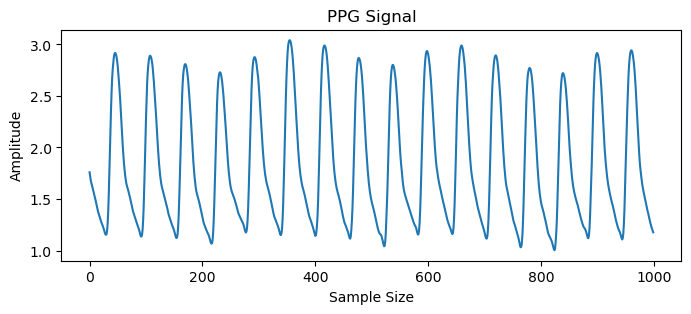

In [7]:
plt.figure(figsize=(8, 3))
plt.title('PPG Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(ppg_signals["patient_1"][:1000])
plt.show()

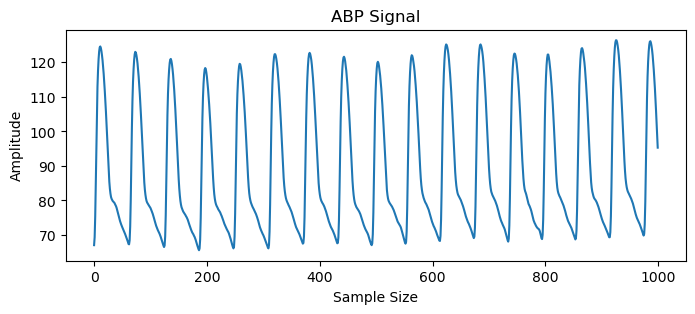

In [8]:
plt.figure(figsize=(8, 3))
plt.title('ABP Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(abp_signals["patient_1"][:1000])
plt.show()

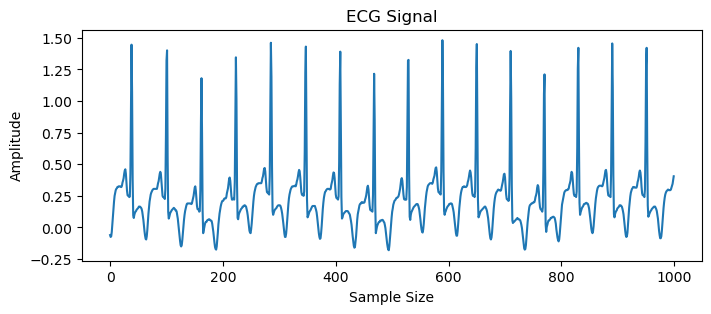

In [9]:
plt.figure(figsize=(8, 3))
plt.title('ECG Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(ecg_signals["patient_1"][:1000])
plt.show()

In [10]:
features = {}

for index in range(1, sample_file.shape[0] + 1):
    features["patient_{}".format(index)] = {}

Calculating:

1. Photoplethysmogram intensity ratio
2. Maximum amplitude of the pulse signal
3. Minimum amplitude of the pulse signal
4. Viscosity of the blood, calculated as AC amplitude of the pulse signal
5. Systolic width @ 10% of the pulse amplitude

In [11]:
for index in range(1, sample_file.shape[0] + 1):
    patient_sample = ppg_signals["patient_{}".format(index)]
    
    max_amplitude = np.max(patient_sample) # Intensity High
    min_amplitude = np.min(patient_sample) + EPSILON # Intensity Low
    
    ppg_intensity_ratio = max_amplitude / min_amplitude # Photoplethysmogram intensity ratio
    ac_amplitude = max_amplitude - min_amplitude # Viscosity of Blood
    
    pulse_amplitude_10 = 0.1 * ac_amplitude
    peaks, _ = find_peaks(patient_sample, height=pulse_amplitude_10)
    systolic_width_10 = np.mean(np.diff(peaks)) / SAMPLING_FREQUENCY # Systolic Width @ 10%
    
    features["patient_{}".format(index)]["PIR"] = ppg_intensity_ratio
    features["patient_{}".format(index)]["IH"] = max_amplitude
    features["patient_{}".format(index)]["IL"] = min_amplitude + EPSILON
    features["patient_{}".format(index)]["MEU"] = ac_amplitude
    features["patient_{}".format(index)]["SW10"] = systolic_width_10

In [12]:
features

{'patient_1': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,
  'SW10': 0.4638173168411037},
 'patient_2': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,
  'SW10': 0.48241584158415846},
 'patient_3': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,
  'SW10': 0.4650896391152503},
 'patient_4': {'PIR': 3997067448.6803517,
  'IH': 3.997067448680352,
  'IL': 2e-09,
  'MEU': 3.997067447680352,
  'SW10': 0.48983537653239934},
 'patient_5': {'PIR': 11.467787081984463,
  'IH': 4.001955034213099,
  'IL': 0.34897360903812324,
  'MEU': 3.6529814261749753,
  'SW10': 0.48742049469964666},
 'patient_6': {'PIR': 3.966002339909472,
  'IH': 3.3069403714565007,
  'IL': 0.833822093886608,
  'MEU': 2.473118278569893,
  'SW10': 0.5409967637540454},
 'patient_7': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,


Calculating:  
1. The time interval between Q and T of ECG corrected for heart rate.
2. The time interval between two successive R wave of ECG
3. The time interval between Q and T of ECG
4. The time interval between T and Q of successive ECG
5. From the start of the P wave to the start of the QRS complex
6. From the start of the Q wave to the start of the QRS complex
7. From the start to the end of the QRS complex
8. Amplitude of P wave and it represents the atrial depolarization
9. Amplitude of Q wave, negative deflection of QRS complex
10. Amplitude of R wave and it represents the ventricular depolarization
11. Amplitude of S wave
12. Amplitude of T wave and it represents the atrial repolarization

In [ ]:
!pip install biosppy

In [14]:
from biosppy.signals import ecg

In [41]:
%%time

for index in range(1, sample_file.shape[0] + 1):

    ecg_signal = ecg_signals["patient_{}".format(index)]

    out = ecg.ecg(signal=ecg_signal, sampling_rate=SAMPLING_FREQUENCY, show=False)

    r_peaks = out['rpeaks']

    rr_intervals = np.diff(r_peaks) / SAMPLING_FREQUENCY * 1000 # Time interval between two successive R wave of ECG in ms
    qt_fraction = 0.45
    qt_interval = rr_intervals * qt_fraction
    qt_corrected = qt_interval / np.sqrt(rr_intervals) # Time interval between Q and T of ECG corrected for heart rate
    
    q_wave_indices = np.array([np.argmin(ecg_signal[r:r + int(0.06 * SAMPLING_FREQUENCY)]) + r for r in r_peaks])
    t_wave_indices = np.array([r + np.argmax(ecg_signal[r:r + int(0.4 * SAMPLING_FREQUENCY)]) for r in r_peaks])
    qt_intervals = (t_wave_indices - q_wave_indices) / SAMPLING_FREQUENCY # QT Intervals
    tq_intervals = (q_wave_indices[1:] - t_wave_indices[:-1]) / SAMPLING_FREQUENCY # TQ Intervals for Successive ECG
    q_qrs_intervals = (r_peaks - q_wave_indices) / SAMPLING_FREQUENCY # Q wave to the start of the QRS complex

    p_wave_indices = []
    for r_peak_index in r_peaks:
        
        window_start = max(0, r_peak_index - int(0.1 * SAMPLING_FREQUENCY))
        window_end = r_peak_index

        p_wave_index = window_start + np.argmin(ecg_signal[window_start:window_end])
        p_wave_indices.append(p_wave_index)
        
    p_wave_indices = np.array(p_wave_indices)

    pw_rw_intervals = []
    
    for p_index, r_index in zip(p_wave_indices, r_peaks):
        time_interval = (r_index - p_index) / SAMPLING_FREQUENCY
        pw_rw_intervals.append(time_interval)
    pw_rw_intervals = np.array(pw_rw_intervals) # Time interval between P and QRS complex
    
    q_wave_indices = []
    for r_peak_index in r_peaks:
        window_start = max(0, r_peak_index - int(0.05 * SAMPLING_FREQUENCY))
        window_end = r_peak_index

        q_wave_index = window_start + np.argmin(ecg_signal[window_start:window_end])
        q_wave_indices.append(q_wave_index)
        
    q_wave_indices = np.array(q_wave_indices)
    
    qr_intervals = []
    for q_index, r_index in zip(q_wave_indices, r_peaks):
        time_interval = (r_index - q_index) / SAMPLING_FREQUENCY
        qr_intervals.append(time_interval)
        
    qr_intervals = np.array(qr_intervals) # Time interval between Q and QRS complex

    features["patient_{}".format(index)]["QTC"] = np.mean(qt_corrected)
    features["patient_{}".format(index)]["RR"] = np.mean(rr_intervals) / 1000
    features["patient_{}".format(index)]["QT"] = np.mean(qt_intervals)
    features["patient_{}".format(index)]["TQ"] = np.mean(tq_intervals)
    features["patient_{}".format(index)]["PR"] = np.mean(pw_rw_intervals)
    features["patient_{}".format(index)]["QR"] = np.mean(qr_intervals)
    
    q_wave_indices = []
    s_wave_indices = []
    for r_peak_index in r_peaks:
        window_start = max(0, r_peak_index - int(0.05 * SAMPLING_FREQUENCY))
        window_end = min(len(ecg_signal) - 1, r_peak_index + int(0.05 * SAMPLING_FREQUENCY))

        q_wave_index = window_start + np.argmin(ecg_signal[window_start:r_peak_index])
        q_wave_indices.append(q_wave_index)

        s_wave_index = r_peak_index + np.argmin(ecg_signal[r_peak_index:window_end])
        s_wave_indices.append(s_wave_index)
        
    q_wave_indices = np.array(q_wave_indices)
    s_wave_indices = np.array(s_wave_indices)
    
    qrs_intervals = []
    for q_index, s_index in zip(q_wave_indices, s_wave_indices):
        time_interval = (s_index - q_index) / SAMPLING_FREQUENCY
        qrs_intervals.append(time_interval)
        
    qrs_intervals = np.array(qrs_intervals) # Time interval from the start to the end of QRS complex
    
    p_wave_amplitudes = ecg_signal[p_wave_indices]
    p_wave_amplitude = np.max(p_wave_amplitudes) - np.min(p_wave_amplitudes) # Compute P-wave amplitude

    q_wave_amplitudes = ecg_signal[q_wave_indices]
    q_wave_amplitude = np.max(q_wave_amplitudes) - np.min(q_wave_amplitudes) # Compute Q-wave amplitude

    r_wave_amplitudes = ecg_signal[r_peaks]
    r_wave_amplitude = np.max(r_wave_amplitudes) - np.min(r_wave_amplitudes) # Compute R-wave amplitude

    s_wave_amplitudes = ecg_signal[s_wave_indices]
    s_wave_amplitude = np.max(s_wave_amplitudes) - np.min(s_wave_amplitudes) # Compute S-wave amplitude
    
    t_wave_amplitudes = ecg_signal[t_wave_indices]
    t_wave_amplitude = np.max(t_wave_amplitudes) - np.min(t_wave_amplitudes) # Compute T-wave amplitude
    
    features["patient_{}".format(index)]["QRS"] = np.mean(qrs_intervals)
    features["patient_{}".format(index)]["P"] = np.mean(p_wave_amplitude)
    features["patient_{}".format(index)]["Q"] = np.mean(q_wave_amplitude)
    features["patient_{}".format(index)]["R"] = np.mean(r_wave_amplitude)
    features["patient_{}".format(index)]["S"] = np.mean(s_wave_amplitude)
    features["patient_{}".format(index)]["T"] = np.mean(s_wave_amplitude)

CPU times: total: 2min 55s
Wall time: 2min 56s


In [39]:
features

{'patient_1': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,
  'SW10': 0.4638173168411037,
  'QTC': 9.961494847020472,
  'RR': 0.49041691842900303,
  'QT': -0.02663179074446681,
  'TQ': 0.5170513595166163,
  'PR': 0.032973843058350105,
  'QR': 0.03200000000000001,
  'QRS': 0.0604185110663984,
  'P': 0.5557184750733137,
  'Q': 0.5557184750733137,
  'R': 0.5654936461388075,
  'S': 0.4252199413489736,
  'T': 0.4252199413489736},
 'patient_2': {'PIR': 4001955034.2130985,
  'IH': 4.001955034213099,
  'IL': 2e-09,
  'MEU': 4.001955033213099,
  'SW10': 0.48241584158415846,
  'QTC': 10.113403591155501,
  'RR': 0.5054205607476635,
  'QT': -0.025784232365145234,
  'TQ': 0.5312066458982347,
  'PR': 0.03767634854771785,
  'QR': 0.03589211618257262,
  'QRS': 0.06312033195020747,
  'P': 0.6104594330400781,
  'Q': 0.6055718475073313,
  'R': 0.5909090909090909,
  'S': 0.8509286412512218,
  'T': 0.8509286412512218},
 'patient_3': {'PIR': 4001955034.213

In [42]:
pd.DataFrame(features)

,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,patient_8,patient_9,patient_10,...,patient_991,patient_992,patient_993,patient_994,patient_995,patient_996,patient_997,patient_998,patient_999,patient_1000
PIR,4.001955e+09,4.001955e+09,4.001955e+09,3.997067e+09,11.467787,3.966002,4.001955e+09,4.225885,4.490931,19.584210,...,5.516963,4.131414,3.259794,255.874984,4.001955e+09,3.871043,5.621083,3.935185,4.653226,3.180915
IH,4.001955e+00,4.001955e+00,4.001955e+00,3.997067e+00,4.001955,3.306940,4.001955e+00,3.383187,3.630499,3.637341,...,3.338221,3.226784,3.090909,4.001955,4.001955e+00,3.227761,3.857283,3.323558,3.384164,3.128055
IL,2.000000e-09,2.000000e-09,2.000000e-09,2.000000e-09,0.348974,0.833822,2.000000e-09,0.800587,0.808407,0.185728,...,0.605083,0.781036,0.948192,0.015640,2.000000e-09,0.833822,0.686217,0.844575,0.727273,0.983382
MEU,4.001955e+00,4.001955e+00,4.001955e+00,3.997067e+00,3.652981,2.473118,4.001955e+00,2.582600,2.822092,3.451613,...,2.733138,2.445748,2.142717,3.986315,4.001955e+00,2.393939,3.171065,2.478983,2.656891,2.144673
SW10,4.638173e-01,4.824158e-01,4.650896e-01,4.898354e-01,0.487420,0.540997,5.257386e-01,0.418987,0.434667,0.430588,...,0.488100,0.437352,0.383200,0.506065,4.471444e-01,0.482167,0.439209,0.349737,0.332790,0.325127
QTC,9.961495e+00,1.011340e+01,1.025961e+01,1.016300e+01,10.583524,10.584958,1.052246e+01,10.529940,10.566807,10.285635,...,13.152203,13.331927,13.976439,12.849089,1.286026e+01,12.744976,13.216274,13.263842,13.724963,13.931878
RR,4.904169e-01,5.054206e-01,5.201567e-01,5.103927e-01,0.553714,0.553483,5.470164e-01,0.547571,0.551407,0.522462,...,0.860364,0.879887,0.964800,0.822919,8.241188e-01,0.819259,0.869511,0.874469,0.935448,0.961405
QT,-2.663179e-02,-2.578423e-02,-2.459452e-02,-2.672263e-02,-0.025584,-0.026139,-2.524085e-02,-0.026807,-0.026571,-0.023429,...,-0.041956,-0.042444,-0.042500,-0.041474,-2.723153e-02,-0.025714,-0.037890,-0.041561,-0.038508,-0.043627
TQ,5.170514e-01,5.312066e-01,5.447415e-01,5.371105e-01,0.579300,0.579629,5.722507e-01,0.574571,0.578370,0.546462,...,0.902364,0.922479,1.006933,0.864432,8.512871e-01,0.844148,0.907378,0.915951,0.978345,1.004973
PR,3.297384e-02,3.767635e-02,3.287614e-02,2.866423e-02,0.036969,0.038205,3.691715e-02,0.040281,0.041714,0.041714,...,0.065778,0.064111,0.061000,0.062947,6.333005e-02,0.061714,0.066110,0.059610,0.061153,0.069867
